In [12]:
import numpy as np
from numpy import inf
import matplotlib.pyplot as plt
fig_num = 1

In [13]:
def check_symmetric(A, rtol=1e-05, atol=1e-08):
    return np.allclose(A, A.T, rtol=rtol, atol=atol)

In [14]:
def TDMSolver(T, d_original):
   
    a = (np.diag(T,k = -1)).copy()
    b = (np.diag(T,k = 0)).copy()
    c = (np.diag(T,k = 1)).copy()
    d = d_original.copy()
    
    
    nf = d.shape[0] 
    for i in range(1, nf):
        m = a[i-1]/b[i-1]
        b[i] -=  m*c[i-1] 
        d[i] -=  m*d[i-1]
    
    x = b
    x[-1] = d[-1]/b[-1]

    for i in range(nf-2, -1, -1):
        x[i] = (d[i]-c[i]*x[i+1])/b[i]

    return x

In [15]:
def construct_A(size,tau):

    A= np.random.uniform(-1,1,(size,size))
    A = np.triu(A,k = 1)
    A[np.where(np.abs(A) > tau)] = 0
    A += A.T 
    A += np.eye(size)
    return A

In [16]:
def construct_b(A):
    m = A.shape[0]
    sigmas = [0.0001,0.01,1]
    b_i_j = np.zeros((3,10,m))
    x0_j = np.zeros((10,m)) 
    for j in range(b_i_j.shape[1]):
        x0 = np.random.standard_normal(m)
        b0 = np.matmul(A,x0)
        x0_j[j] = x0
        for i in range(b_i_j.shape[0]):
            b_i_j[i,j,:] = (b0 + np.random.normal(0,sigmas[i],m))
                
    return b_i_j,x0_j      

In [17]:
A_100_01 = construct_A(100,0.1)
A_500_01 = construct_A(500,0.1)
A_2500_01 = construct_A(2500,0.1)

A_100_001 = construct_A(100,0.01)
A_500_001 = construct_A(500,0.01)
A_2500_001 = construct_A(2500,0.01)


In [18]:
b_i_j_100_01,x0_j_100_01 = construct_b(A_100_01)
b_i_j_500_01,x0_j_500_01 = construct_b(A_500_01)
b_i_j_2500_01,x0_j_2500_01 = construct_b(A_2500_01)

b_i_j_100_001,x0_j_100_001 = construct_b(A_100_001)
b_i_j_500_001,x0_j_500_001 = construct_b(A_500_001)
b_i_j_2500_001,x0_j_2500_001 = construct_b(A_2500_001)

In [19]:
def pseudoSolver(A,b):
    U,S,V_T = np.linalg.svd(A, full_matrices = False)
    S_pinv = np.diag(1/S)
    S_pinv[S_pinv == inf] = 0
    A_pinv = np.matmul(V_T.transpose(),np.matmul(S_pinv,U.transpose()))
    x_hat = np.matmul(A_pinv,b)
    return x_hat

In [20]:
def getPseudoError(A,b_i_j,x0_j):
    
    E_S_i = np.zeros((b_i_j.shape[0]))
    
    U,S,V_T = np.linalg.svd(A, full_matrices = False)
    S_pinv = np.diag(1/S)
    S_pinv[S_pinv == inf] = 0
    A_pinv = np.matmul(V_T.transpose(),np.matmul(S_pinv,U.transpose()))
    x_hat_i_j = np.zeros((A.shape[0]))
    
    for i in range(b_i_j.shape[0]):
        error_s_sum = 0
        for j in range(b_i_j.shape[1]):
            x_hat_i_j = np.matmul(A_pinv,b_i_j[i,j])
            error_s_sum += np.linalg.norm(x0_j[j] - x_hat_i_j)**2
        E_S_i[i] = np.sqrt(error_s_sum/b_i_j.shape[1])
  
    return E_S_i

In [21]:
Es_pseudo_100_01 = getPseudoError(A_100_01,b_i_j_100_01,x0_j_100_01)
Es_pseudo_500_01 = getPseudoError(A_500_01,b_i_j_500_01,x0_j_500_01)
Es_pseudo_2500_01 = getPseudoError(A_2500_01,b_i_j_2500_01,x0_j_2500_01)

Es_pseudo_100_001 = getPseudoError(A_100_001,b_i_j_100_001,x0_j_100_001)
Es_pseudo_500_001 = getPseudoError(A_500_001,b_i_j_500_001,x0_j_500_001)
Es_pseudo_2500_001 = getPseudoError(A_2500_001,b_i_j_2500_001,x0_j_2500_001)


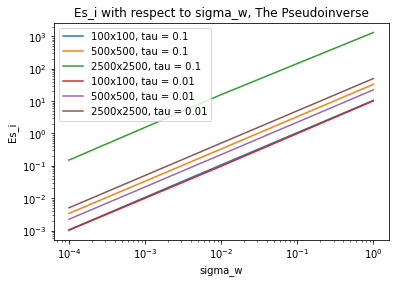

In [22]:
sigmas = np.array([0.0001,0.01,1])


plt.figure(fig_num)
fig_num += 1
plt.plot(sigmas,Es_pseudo_100_01, label = '100x100, tau = 0.1')
plt.plot(sigmas,Es_pseudo_500_01, label = '500x500, tau = 0.1')
plt.plot(sigmas,Es_pseudo_2500_01,label = '2500x2500, tau = 0.1')
plt.plot(sigmas,Es_pseudo_100_001, label = '100x100, tau = 0.01')
plt.plot(sigmas,Es_pseudo_500_001, label = '500x500, tau = 0.01')
plt.plot(sigmas,Es_pseudo_2500_001, label = '2500x2500, tau = 0.01')

plt.title('Es_i with respect to sigma_w, The Pseudoinverse')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Es_i')
plt.xlabel('sigma_w')
plt.legend()
plt.show(block=False)




In [23]:
def CGSolver(A, b, max_iter, tol):

    r = b.copy()
    d = r.copy()
    x_hat = np.zeros((b.shape))
    ort = -1
    Q = np.zeros((b.shape[0],b.shape[0] + 1))
    #Q[:,0] = b / np.linalg.norm(b)
    orth_residual = []
    display = 10
    
    for k in range(max_iter):
        A_d = np.matmul(A,d)
        Q[:,k] = r/ np.linalg.norm(r)
        print(r.shape)
        prev_product = np.matmul(r.T,r)
        alpha = prev_product/np.matmul(d.T,A_d)
        x_hat = x_hat + alpha*d
        r = r - alpha*A_d #new residual
       
        if( k < display):
            orth_residual.append(np.linalg.norm(np.matmul(Q[:,:k+1].T,Q[:,:k+1])-np.eye(k+1,k+1)))
        
        if np.sqrt(np.sum((r**2))) < tol:
            print('Stopped Iteration at: ', k + 1)
            
            break
        else:
            beta = np.matmul(r.T,r)/prev_product
            d = r + beta*d
    #print(f'Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to {display}:{orth_residual[:display]}')
    
    return x_hat

In [24]:
x_hat = CGSolver(A_100_001,b_i_j_100_001[0,0,:],500,1e-13)

(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
Stopped Iteration at:  7


In [14]:
def getCGError(A,b_i_j,x0_j,max_iteration, tolerance):
    
    E_S_i = np.zeros((b_i_j.shape[0]))

    x_hat_i_j = np.zeros((A.shape[0]))
    
    for i in range(b_i_j.shape[0]):
        error_s_sum = 0
        error_res = 0
        for j in range(b_i_j.shape[1]):
            x_hat_i_j = CGSolver(A = A, b = b_i_j[i,j], tol=tolerance, max_iter = max_iteration)
            error_s_sum += np.linalg.norm(x0_j[j,:] - x_hat_i_j)**2
        E_S_i[i] = np.sqrt(error_s_sum/b_i_j.shape[1])
        
  
    return E_S_i

In [15]:
def CGSolverO(A,b,max_iter):

    r = b.copy()
    d = r.copy()
    x_hat = np.zeros((b.shape))
    residual = np.zeros((max_iter))
    
    for k in range(max_iter):
        A_d = np.matmul(A,d)
        prev_product = np.matmul(r.T,r)
        alpha = prev_product / np.matmul(d.T,A_d)
        x_hat = x_hat + alpha*d
        r = r - alpha * A_d
        beta = np.matmul(r.T,r) / prev_product
        d = r + beta * d
        residual[k] = np.linalg.norm(b-np.matmul(A,x_hat))
        
    return residual

In [16]:
def getCGErrorO(A,b_i_j,x0_j,maxiter):
    E_O_i = np.zeros((b_i_j.shape[0],maxiter))
    
    for i in range(b_i_j.shape[0]):
        error_o_sum = 0
        for j in range(b_i_j.shape[1]):
            residual = CGSolverO(A = A,b = b_i_j[i,j], max_iter = maxiter)
            error_o_sum += residual**2
        E_O_i[i,:] = np.sqrt(error_o_sum/b_i_j.shape[1])
        
  
    return E_O_i

In [17]:

Es_cg_100_01 = getCGError(A_100_01,b_i_j_100_01,x0_j_100_01,max_iteration = A_100_01.shape[0], tolerance =1e-15)
Es_cg_500_01 = getCGError(A_500_01,b_i_j_500_01,x0_j_500_01,max_iteration = A_500_01.shape[0], tolerance =1e-15)
Es_cg_2500_01 = getCGError(A_2500_01,b_i_j_2500_01,x0_j_2500_01,max_iteration = A_2500_01.shape[0], tolerance = 1e-15) # takes long

Es_cg_100_001 = getCGError(A_100_001,b_i_j_100_001,x0_j_100_001,max_iteration = A_100_001.shape[0], tolerance = 1e-15)
Es_cg_500_001 = getCGError(A_500_001,b_i_j_500_001,x0_j_500_001,max_iteration = A_500_001.shape[0], tolerance = 1e-15)
Es_cg_2500_001 = getCGError(A_2500_001,b_i_j_2500_001,x0_j_2500_001,max_iteration = A_2500_001.shape[0], tolerance = 1e-15)

Eo_cg_100_01 = getCGErrorO(A_100_01,b_i_j_100_01,x0_j_100_01,maxiter = 20)
Eo_cg_500_01 = getCGErrorO(A_500_01,b_i_j_500_01,x0_j_500_01,maxiter = 20)
Eo_cg_2500_01 = getCGErrorO(A_2500_01,b_i_j_2500_01,x0_j_2500_01,maxiter = 20)

Eo_cg_100_001 = getCGErrorO(A_100_001,b_i_j_100_001,x0_j_100_001, maxiter = 20)
Eo_cg_500_001 = getCGErrorO(A_500_001,b_i_j_500_001,x0_j_500_001, maxiter = 20)
Eo_cg_2500_001 = getCGErrorO(A_2500_001,b_i_j_2500_001,x0_j_2500_001,maxiter = 20)

Stopped Iteration at:  22
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 20: [0.0, 6.028553680015885e-16, 1.1064906462036345e-15, 1.3201445276039004e-15, 1.912948720230726e-15, 3.3504449461095506e-15, 4.908808666056938e-15, 6.721823159757913e-15, 1.0377814937087361e-14, 1.5743402925556942e-14]
Stopped Iteration at:  22
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 20: [2.220446049250313e-16, 8.203777153934103e-16, 2.5568677536291223e-15, 3.4793963559441402e-15, 5.684490816561621e-15, 7.465109484831963e-15, 9.787312783751511e-15, 1.1852396273727375e-14, 1.339352471620286e-14, 1.436240982093968e-14]
Stopped Iteration at:  22
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 20: [2.220446049250313e-16, 1.3345459270282619e-15, 2.4566894316521715e-15, 4.269716227674397e-15, 5.3806733688359964e-15, 5.89048319031105e-15, 6.313679112097094e-15, 6.69417789368838e-15, 7.0275556723624256e-15, 8.577169681865717e-15]
Stopped Iteration at:  22
Frobenius_norm(Q_k.T Q_k - I_k) for iter

Stopped Iteration at:  52
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 20: [4.440892098500626e-16, 2.8736782160965576e-16, 7.537288662886019e-16, 1.1538956261688732e-15, 1.8197823912081465e-15, 2.3789330743193168e-15, 3.2505234883908787e-15, 4.011392566452649e-15, 4.741317488089731e-15, 5.4501104965703906e-15]
Stopped Iteration at:  51
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 20: [2.220446049250313e-16, 1.2329479223507982e-15, 1.6735398033439563e-15, 1.881833991441254e-15, 2.326428139862267e-15, 2.7745355128398728e-15, 3.236737427636144e-15, 3.630940765516913e-15, 4.117022614893889e-15, 4.719304986604542e-15]
Stopped Iteration at:  51
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 20: [6.661338147750939e-16, 1.7076517803466311e-15, 2.2377058737556798e-15, 2.8635005634699597e-15, 3.3264010236719747e-15, 3.700162635938578e-15, 4.076727055710663e-15, 4.441390393262554e-15, 4.891010091828191e-15, 5.336712989049762e-15]
Stopped Iteration at:  51
Frobenius_norm(Q_k.

Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 20: [4.440892098500626e-16, 9.878729022424218e-16, 1.212029875331953e-15, 1.4979536224790831e-15, 2.046979416963574e-15, 3.340494184060546e-15, 4.360858158624986e-15, 4.607537170200389e-14, 8.284020130195708e-14, 1.1532603196597317e-13]
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 20: [4.440892098500626e-16, 5.312110919374516e-16, 6.978388092114868e-16, 1.046450200942357e-15, 1.2350866259140191e-15, 1.241768721547238e-15, 1.4338023426472156e-15, 3.2548889456753325e-15, 5.380472926664164e-15, 7.205824076145107e-15]
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 20: [4.440892098500626e-16, 4.089700273133082e-16, 6.352099867791221e-16, 7.464130464890864e-16, 8.733779412527826e-16, 1.0910582721741773e-15, 1.1976331781541967e-15, 1.5155983950367194e-15, 1.8202417045117624e-15, 2.011000163672915e-15]
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 20: [8.881784197001252e-16, 2.564353474817912e-15, 3.314487648042738e-15, 

Stopped Iteration at:  10
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 20: [2.220446049250313e-16, 1.144513081019228e-14, 3.606399618624428e-14, 5.390137340573383e-14, 7.599807037239373e-14, 8.979196923611966e-14, 9.95302881184218e-14, 1.0351545822643223e-13, 1.0432841206381321e-13, 1.1073036583247405e-13]
Stopped Iteration at:  10
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 20: [2.220446049250313e-16, 1.1084978027237408e-15, 9.694895950147108e-15, 1.318837515554847e-14, 2.3134977892598233e-14, 4.509759516661041e-14, 6.735351063026702e-14, 8.603915293240423e-14, 1.063623102471134e-13, 1.2360728669527117e-13]
Stopped Iteration at:  10
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 20: [2.220446049250313e-16, 1.3320650716333917e-14, 1.6236273997571606e-14, 1.872902973149662e-14, 1.9359369066753803e-14, 2.4925506997114756e-14, 4.216438209722596e-14, 6.942651593061563e-14, 9.548216480521495e-14, 1.2034687208075923e-13]
Stopped Iteration at:  10
Frobenius_norm(Q_k.T Q

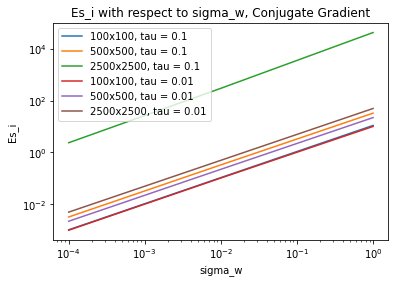

In [18]:
plt.figure(fig_num)
fig_num += 1

plt.plot(sigmas,Es_cg_100_01, label = '100x100, tau = 0.1')
plt.plot(sigmas,Es_cg_500_01, label = '500x500, tau = 0.1')
plt.plot(sigmas,Es_cg_2500_01,label = '2500x2500, tau = 0.1')
plt.plot(sigmas,Es_cg_100_001, label = '100x100, tau = 0.01')
plt.plot(sigmas,Es_cg_500_001, label = '500x500, tau = 0.01')
plt.plot(sigmas,Es_cg_2500_001, label = '2500x2500, tau = 0.01')

plt.title('Es_i with respect to sigma_w, Conjugate Gradient')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Es_i')
plt.xlabel('sigma_w')
plt.legend()
plt.show(block=False)

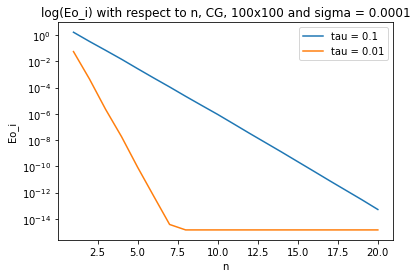

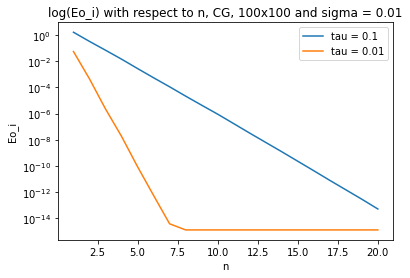

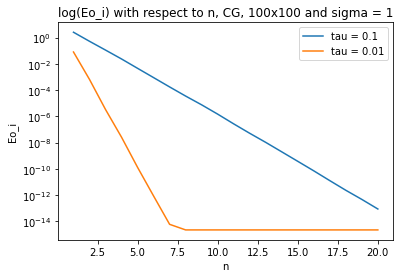

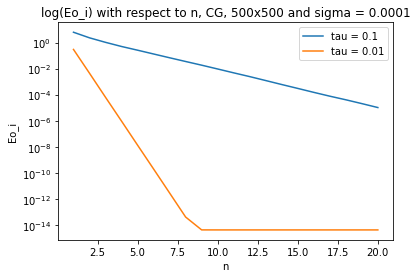

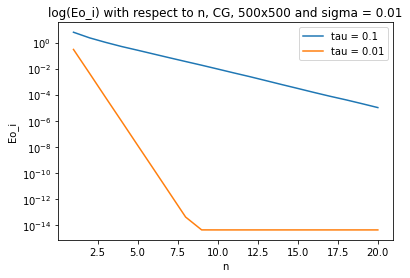

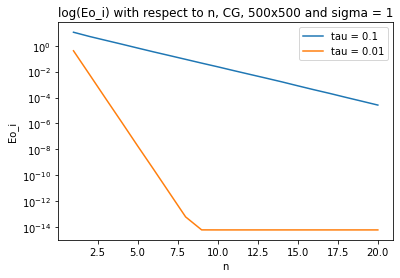

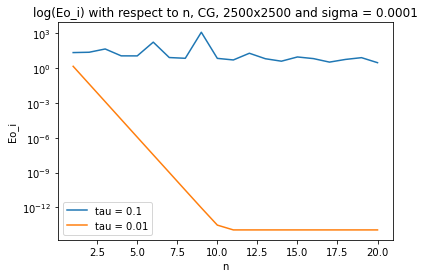

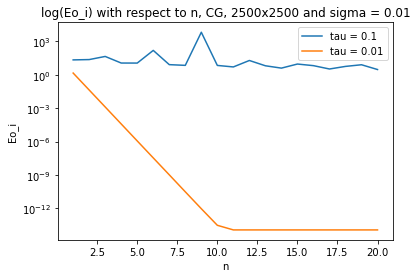

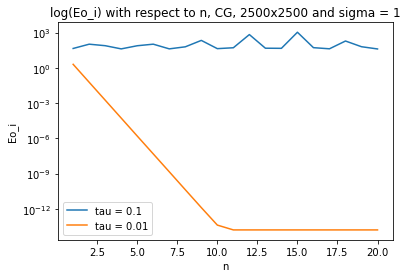

In [19]:
plt.figure(fig_num)
fig_num += 1
plt.plot(np.arange(1,21),Eo_cg_100_01[0,:], label = 'tau = 0.1')
plt.plot(np.arange(1,21),Eo_cg_100_001[0,:],label = 'tau = 0.01')
plt.title('log(Eo_i) with respect to n, CG, 100x100 and sigma = 0.0001')
plt.yscale('log')
plt.ylabel('Eo_i')
plt.xlabel('n')
plt.legend() 
plt.show(block=False)

plt.figure(fig_num)
fig_num += 1
plt.plot(np.arange(1,21),Eo_cg_100_01[1,:], label = 'tau = 0.1')
plt.plot(np.arange(1,21),Eo_cg_100_001[1,:],label = 'tau = 0.01')
plt.title('log(Eo_i) with respect to n, CG, 100x100 and sigma = 0.01')
plt.yscale('log')
plt.ylabel('Eo_i')
plt.xlabel('n')
plt.legend() 
plt.show(block=False)

plt.figure(fig_num)
fig_num += 1
plt.plot(np.arange(1,21),Eo_cg_100_01[2,:], label = 'tau = 0.1')
plt.plot(np.arange(1,21),Eo_cg_100_001[2,:],label = 'tau = 0.01')
plt.title('log(Eo_i) with respect to n, CG, 100x100 and sigma = 1')
plt.yscale('log')
plt.ylabel('Eo_i')
plt.xlabel('n')
plt.legend() 
plt.show(block=False)

plt.figure(fig_num)
fig_num += 1
plt.plot(np.arange(1,21),Eo_cg_500_01[0,:], label = 'tau = 0.1')
plt.plot(np.arange(1,21),Eo_cg_500_001[0,:],label = 'tau = 0.01')
plt.title('log(Eo_i) with respect to n, CG, 500x500 and sigma = 0.0001')
plt.yscale('log')
plt.ylabel('Eo_i')
plt.xlabel('n')
plt.legend() 
plt.show(block=False)

plt.figure(fig_num)
fig_num += 1
plt.plot(np.arange(1,21),Eo_cg_500_01[1,:], label = 'tau = 0.1')
plt.plot(np.arange(1,21),Eo_cg_500_001[1,:],label = 'tau = 0.01')
plt.title('log(Eo_i) with respect to n, CG, 500x500 and sigma = 0.01')
plt.yscale('log')
plt.ylabel('Eo_i')
plt.xlabel('n')
plt.legend() 
plt.show(block=False)

plt.figure(fig_num)
fig_num += 1
plt.plot(np.arange(1,21),Eo_cg_500_01[2,:], label = 'tau = 0.1')
plt.plot(np.arange(1,21),Eo_cg_500_001[2,:],label = 'tau = 0.01')
plt.title('log(Eo_i) with respect to n, CG, 500x500 and sigma = 1')
plt.yscale('log')
plt.ylabel('Eo_i')
plt.xlabel('n')
plt.legend() 
plt.show(block=False)

plt.figure(fig_num)
fig_num += 1
plt.plot(np.arange(1,21),Eo_cg_2500_01[0,:], label = 'tau = 0.1')
plt.plot(np.arange(1,21),Eo_cg_2500_001[0,:],label = 'tau = 0.01')
plt.title('log(Eo_i) with respect to n, CG, 2500x2500 and sigma = 0.0001')
plt.yscale('log')
plt.ylabel('Eo_i')
plt.xlabel('n')
plt.legend() 
plt.show(block=False)

plt.figure(fig_num)
fig_num += 1
plt.plot(np.arange(1,21),Eo_cg_2500_01[1,:], label = 'tau = 0.1')
plt.plot(np.arange(1,21),Eo_cg_2500_001[1,:],label = 'tau = 0.01')
plt.title('log(Eo_i) with respect to n, CG, 2500x2500 and sigma = 0.01')
plt.yscale('log')
plt.ylabel('Eo_i')
plt.xlabel('n')
plt.legend() 
plt.show(block=False)

plt.figure(fig_num)
fig_num += 1
plt.plot(np.arange(1,21),Eo_cg_2500_01[2,:], label = 'tau = 0.1')
plt.plot(np.arange(1,21),Eo_cg_2500_001[2,:],label = 'tau = 0.01')
plt.title('log(Eo_i) with respect to n, CG, 2500x2500 and sigma = 1')
plt.yscale('log')
plt.ylabel('Eo_i')
plt.xlabel('n')
plt.legend() 
plt.show(block=False)

In [20]:
 def GMRESSolver_arnoldi(A,b_original,max_iter,tol):
    
    b = b_original.copy()
    n = A.shape[0]
    H_tilda = np.zeros((n+1,n))
    q1 = b / np.linalg.norm(b)
    Q = np.zeros((n,n+1))
    
    e_1 = np.zeros((n+1,1))
    e_1[0,0] = np.linalg.norm(b)
    x_hat = np.zeros((b.shape))
    
    Q[:,0] = q1
    
    for k in range(0,max_iter): # 0,..,max_iter -1
        v = np.matmul(A,Q[:,k])
        
        for j in range(0,k+1): #0,..k-1
            
            H_tilda[j,k] = np.matmul(Q[:,j].T,v)

            v = v - H_tilda[j,k] * Q[:,j]
            
        H_tilda[k+1,k] = np.linalg.norm(v) #DOGRU
        
        Q[:,k+1] = v / H_tilda[k+1,k]
        
        q_lst,r_lst =np.linalg.qr(H_tilda[:k+1,:k+1])
        d = np.matmul(np.linalg.inv(r_lst),np.matmul(q_lst.T,e_1[:k+1,0]))
        
        x_hat = np.matmul(Q[:, :k+1],d)
        
        res = np.linalg.norm(b - np.matmul(A,x_hat))
        
        if( res < tol):
            break
    
    return x_hat
    


In [21]:
x_hat = GMRESSolver_arnoldi(A_500_001,b_i_j_500_001[0,0,:],500,1e-13)

In [22]:
def GMRESSolver_lancsoz(A,b_original,max_iter,tol):
    
    b = b_original.copy()#nx1 
    n = A.shape[0] 
    
    
    T_tilda = np.zeros((n+1, n)) 
    Q = np.zeros((n,n + 1)) 
    q1 = (b / np.linalg.norm(b))
    
    
    Q[:,0] = q1 
    
    orth = []
    
    e1 = np.zeros((n+1,1))
    e1[0,0] = np.linalg.norm(b)
    
    x_hat = np.zeros((b.shape))
    
    bk = 0
    display = 10
    for k in range(0,max_iter):# 0,1,.., m-1
        
        qk = Q[:,k]
        
        v = np.dot(A,qk)
        
        ak = np.dot(qk.T,v)
        if (k == 0):
            v = v - ak * qk
        else:
            v = v - bk * qk_prev - ak * qk
            
        bk = np.linalg.norm(v)
        qk_prev = qk
        qk =  v / bk
        Q[:,k + 1] = qk
        
        T_tilda[k,k] = ak
        T_tilda[k+1,k] = bk
        
        if k != max_iter - 1:
            T_tilda[k,k+1] = bk
    
       
        q_lst,r_lst =np.linalg.qr(T_tilda[:k+1,:k+1])
        if(k < display):
            orth.append(np.linalg.norm(np.matmul(Q[:,:k+2].T,Q[:,:k+2])-np.eye(k+2,k+2)))
        
        d = np.dot(np.linalg.pinv(r_lst),np.dot(q_lst.T,e1[:k+1,0]))
        
        #d = np.linalg.lstsq(T_tilda[:k+1,:k+1],e1[:k+1,0],rcond=None)[0]
        x_hat = np.dot(Q[:, :k+1],d)
        
        res = np.linalg.norm(b - np.matmul(A,x_hat))
        if( res < tol):
            print('Stopped at Iteration: ', k + 1)
            break
    print('Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 20:',orth[:display])
    return x_hat


In [23]:
x_hat = GMRESSolver_lancsoz(A_500_001,b_i_j_500_001[0,0,:],500,1e-13)

Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 20: [9.17522780543331e-15, 2.0367362992438397e-14, 2.3746699677498403e-14, 3.734671132872959e-14, 4.901950775791172e-14, 5.62244339137426e-14, 8.012536934599476e-14, 8.936104565859469e-14]


In [24]:
def getGMRESerror_lancsoz(A,b_i_j,x0_j,max_iteration,tolerance):
    
    E_S_i = np.zeros((b_i_j.shape[0]))
    
    x_hat_i_j = np.zeros((A.shape[0]))
    
    for i in range(b_i_j.shape[0]):
        
        error_s_sum = 0
        for j in range(b_i_j.shape[1]):
            
            x_hat_i_j = GMRESSolver_lancsoz(A,b_i_j[i,j,:], max_iteration,tolerance)
            error_s_sum += np.linalg.norm(x0_j[j] - x_hat_i_j)**2
        E_S_i[i] = np.sqrt(error_s_sum/b_i_j.shape[1])
    
  
    return E_S_i


In [25]:
Es_gmres_100_01 = getGMRESerror_lancsoz(A_100_01,b_i_j_100_01,x0_j_100_01,  A_100_01.shape[0], 1e-13)
Es_gmres_500_01 = getGMRESerror_lancsoz(A_500_01,b_i_j_500_01,x0_j_500_01, A_500_01.shape[0], 1e-13)
Es_gmres_2500_01 = getGMRESerror_lancsoz(A_2500_01,b_i_j_2500_01,x0_j_2500_01,  int(A_2500_01.shape[0]/5), 1e-13)

Es_gmres_100_001 = getGMRESerror_lancsoz(A_100_001,b_i_j_100_001,x0_j_100_001,  A_100_001.shape[0], 1e-13)
Es_gmres_500_001 = getGMRESerror_lancsoz(A_500_001,b_i_j_500_001,x0_j_500_001,  A_500_001.shape[0], 1e-13)
Es_gmres_2500_001 = getGMRESerror_lancsoz(A_2500_001,b_i_j_2500_001,x0_j_2500_001,  A_2500_001.shape[0], 1e-13)

Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 20: [8.196270349887548e-16, 2.572617161626564e-15, 4.961579120609259e-15, 6.986820443685001e-15, 9.88209117403587e-15, 1.1218614082107012e-14, 1.436519801910813e-14, 1.632582561301271e-14, 1.8687537841476223e-14, 2.2192909148826074e-14]
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 20: [8.624135525871253e-16, 8.845669620851121e-16, 1.2748505005460074e-15, 1.899676773726831e-15, 4.6187023006474295e-15, 5.940598968487728e-15, 7.516188983478798e-15, 8.7428260922878e-15, 9.599388420409986e-15, 1.0545495388413834e-14]
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 20: [1.9789649316060202e-15, 2.9468852651775916e-15, 4.80162148589589e-15, 5.289790966216495e-15, 9.159080586926606e-15, 1.1132874158965654e-14, 1.4727692636802046e-14, 1.7267940481566243e-14, 2.2171853349282144e-14, 2.3689059525185678e-14]
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 20: [8.596762710934017e-16, 1.5978524526663941e-15, 2.6466896517876902e-15

Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 20: [2.1476128852618802e-15, 2.848513405229342e-15, 5.078020389061902e-15, 7.116405106479477e-15, 8.99421610278456e-15, 1.1241012407596736e-14, 1.3158392368996249e-14, 1.5289200164681832e-14, 1.7073226942676838e-14, 1.9613932788725594e-14]
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 20: [8.511092558054758e-16, 1.070998744231106e-15, 1.7136845478376471e-15, 1.9158882928358595e-15, 2.4291142479079994e-15, 2.5257739767196088e-15, 2.934108158384188e-15, 3.210762742107131e-15, 3.620614175376472e-15, 4.0793945547476814e-15]
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 20: [6.122716891234573e-16, 1.7085310140838063e-15, 2.8689385554926266e-15, 4.696217824112491e-15, 5.570168861982489e-15, 8.2696920963742e-15, 9.125876572962121e-15, 1.1459770175021208e-14, 1.2226845634552696e-14, 1.424020949683827e-14]
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 20: [5.057939674876102e-16, 1.0568976728788289e-15, 2.6257180367267123e

Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 20: [2.222892626598894e-16, 3.137286193944046e-16, 1.014931495521699e-15, 1.8262916363910884e-15, 2.1843423953969358e-15, 2.3964657231934916e-15, 2.870026891820532e-15, 3.7129343260071294e-15, 4.905122468623178e-15, 5.778803882922175e-15]
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 20: [1.4167531605296946e-16, 5.082356784090249e-16, 6.292905595456952e-16, 9.819762935140897e-16, 1.2335723399156895e-15, 1.9486920135848795e-15, 3.4130612828399983e-15, 4.1906998031661896e-15, 5.22978543025975e-15, 6.008663725309343e-15]
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 20: [1.1672434988456387e-15, 1.861401637096475e-15, 2.347150657974562e-15, 5.1751979430398184e-15, 6.348632490839399e-15, 8.76670640455154e-15, 9.618882786095891e-15, 1.122209225533801e-14, 1.139099824359182e-14, 1.3497170528759807e-14]
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 20: [6.260071805686108e-16, 1.2922681330356795e-15, 2.353162865503019e-15

Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 20: [6.5016288026836805e-15, 2.2916234501371187e-14, 6.854155485972802e-14, 1.1367676107367337e-13, 1.538962429793751e-13, 1.6837565260010306e-13, 2.205513483589435e-13, 2.3718191438525675e-13]
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 20: [4.441435902708959e-15, 2.2579439817036713e-14, 3.956201236453534e-14, 5.243692843849694e-14, 5.626839452651234e-14, 7.318476734924034e-14, 8.849720732383869e-14, 9.870072188675909e-14, 1.0807794404674311e-13, 1.2464274607349112e-13]
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 20: [1.5914359030440075e-14, 3.4503609866918274e-14, 6.642648953854139e-14, 8.33168534745358e-14, 1.2671856447386854e-13, 1.3024255573453334e-13, 1.7296925137907148e-13, 1.781806887340563e-13, 2.1582636577698272e-13, 2.198959112760932e-13]
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 20: [1.2948613980027911e-14, 3.071320230180858e-14, 5.777702160707347e-14, 8.205630859348099e-14, 1.3452144103547153

In [25]:
plt.figure(fig_num)
fig_num += 1

plt.plot(sigmas,Es_gmres_100_01, label = '100x100, tau = 0.1')
plt.plot(sigmas,Es_gmres_500_01, label = '500x500, tau = 0.1')
plt.plot(sigmas,Es_gmres_2500_01,label = '2500x2500, tau = 0.1')
plt.plot(sigmas,Es_gmres_100_001, label = '100x100, tau = 0.01')
plt.plot(sigmas,Es_gmres_500_001, label = '500x500, tau = 0.01')
plt.plot(sigmas,Es_gmres_2500_001, label = '2500x2500, tau = 0.01')

plt.title('Es_i with respect to sigma_w, GMRES')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Es_i')
plt.xlabel('sigma_w')

plt.show(block=False)

NameError: name 'Es_gmres_100_01' is not defined

<Figure size 432x288 with 0 Axes>